In [1]:
#load all desired packages
import os
import numpy as np
import pandas as pd
import utils_v3 as utils
from tqdm import tqdm_notebook

#set the GPU number on system that will be used - user will need to change based on available hardware
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model import densenet_2D

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#set training and validation batch sizes, other training parameters, and path to labels
batch_size = 15
val_batch_size = 40
num_epochs = 10
learning_rate = 1e-4

num_workers = 0
gpu_ids = [0]

#parameters determined to be optimal from hyperparameter search
min_grad_lr = 3.981071705534973e-06
thres       = 0.9271293536596975
frozen      = 2
drop_rate   = 0.37525065168117155

full_label_split_path = 'labels/TKR_labels.pkl'
oa_pretrain_path      = 'checkpoints/OA_pred_pretrain_Xray.pth'
best_model_path       = 'checkpoints/param_search_LR_0.0_frozen_2_weight_0.9271_dropout_0.3753.pth'

In [4]:
dev = "cuda"
print(dev)
device = torch.device(dev)

cuda


In [5]:
#load dataframe
label_df = pd.read_pickle(full_label_split_path)

In [6]:
#loads 500x500 radiographs as .raw files and converts to numpy array. Also checks for correct array size
def load_raw(fname):
    raw_array = np.fromfile(fname, dtype=np.float32)
    im = np.reshape(raw_array, (500,500), order='C')
    assert im.shape == (500, 500), 'Found wrong shape: {}, {}'.format(fname, im.shape)
    return im

In [7]:
# dataloader for X-ray images. loads train/val/test dataset as appropriate, and retrieves an item
# and its corresponding label when __getitem__ function is called

class RawData(Dataset):

    def __init__(self, labels_df, set_name):
        
        if set_name == 'train':
            self.labels_df = labels_df.loc[labels_df.set == 0, :]
        elif set_name == 'val':
            self.labels_df = labels_df.loc[labels_df.set == 1, :]
        elif set_name == 'test':
            self.labels_df = labels_df.loc[labels_df.set == 2, :]
        else:
            print("Wrong set name was given")

        self.file_paths = list(self.labels_df['File_Path'])
        self.labels = list(self.labels_df['TKR_in_5_years'])
        self.len = len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'
        fname = self.file_paths[index]
        image = load_raw(fname)
        
        #normalize the image
        image = (image - np.mean(image))/np.std(image)
        
        
        image = np.expand_dims(image, 0)  # (1, 32, 448, 448)

        image = torch.from_numpy(image)
        label = torch.from_numpy(np.asarray(self.labels[index]))
        return image.type(torch.FloatTensor), label.type(torch.LongTensor)

    
    def __len__(self):
        return self.len 

In [8]:
# load the training, validation, and test sets using the dataloader. recall that all cases (eventual TKR in
# 5 years) are duplicated to balance the ratio of cases to controls

trainset = RawData(labels_df=label_df, set_name='train')
valset   = RawData(labels_df=label_df, set_name='val')
testset  = RawData(labels_df=label_df, set_name='test')

print(trainset.len, valset.len, testset.len)

44423 13439 9953


In [9]:
# finalize dataloaders and convert into an ImageDataBunch

trainset_loader = DataLoader(trainset, 
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=num_workers,
                             drop_last=True)

valset_loader = DataLoader(valset, 
                             batch_size=val_batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

testset_loader = DataLoader(testset, 
                             batch_size=val_batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

idb = (ImageDataBunch(train_dl=trainset_loader, valid_dl=valset_loader,test_dl=testset_loader))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


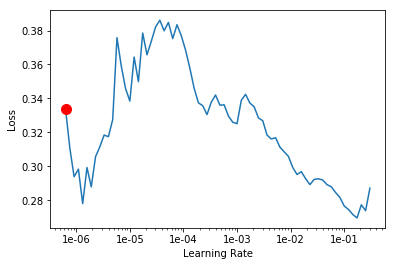

In [63]:
#initialize and set up model with appropriate parameters for last fine-tuning

#weight cross entropy loss function with appropriate weighting found in hyperparameter search
weights = [1-thres,thres]

class_weights = torch.FloatTensor(weights).cuda()

#initialize loss functions and metrics
loss = nn.CrossEntropyLoss(weight = class_weights)

sens = Recall()
prec = Precision()

# Define model with dropout rate found from hyperparameter search
model = densenet_2D.densenet121(bn_size = 4,
                            drop_rate = drop_rate,
                            num_classes = 2)

# load best model
model_dict = model.state_dict()
original_model = torch.load(best_model_path)

# set weights of current model in accordance with best model from hyperparam search
pretrained_dict = {k: v for k, v in original_model['model'].items() if k in model_dict.keys()}
model_dict.update(pretrained_dict)
model.load_state_dict(pretrained_dict, strict=False)

#freeze appropriate number of layers from model (again, determined from hyparparam search)
if frozen!=0:
    body = (nn.Sequential(*list(model.children())[0][:-frozen]))
    for l in body:
        count = 0
        for name, p in l.named_parameters():
            set_grad_val = True
            if 'weight' in name:
                set_grad_val = False
            if 'norm' in name:
                set_grad_val = True
            if 'linear' in name:
                set_grad_val = True
            p.requires_grad_(set_grad_val)

#initialize the model
model = nn.DataParallel(model, device_ids=gpu_ids).cuda()


learn = Learner(idb, 
                model= model, 
                loss_func= loss, 
                metrics = [accuracy, sens, prec],
                model_dir='checkpoints_2D_tuning')

#recalculate optimal learning rate using the newly fine-tuned model 
found_lr = 0
while found_lr == 0:

    learn.lr_find()
    learn.recorder.plot(suggestion = True)
    if hasattr(learn.recorder, 'min_grad_lr'):
        found_lr = 1
        min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
# select optimal learning rate from plot of loss vs. learning rate by inspection
learning_rate = 2e-3

In [64]:
#carry out model fine-tuning

save_name = 'tuning_param_search_LR_'+str(round(min_grad_lr,4))+'_frozen_'+str(frozen)+'_weight_'+str(round(thres,4))+'_dropout_'+str(round(drop_rate,4))

learn.fit_one_cycle(5, learning_rate,
                    callbacks=[SaveModelCallback(learn, name=save_name)])

Better model found at epoch 0 with val_loss value: 0.619762122631073.
Better model found at epoch 1 with val_loss value: 0.5864438414573669.


KeyboardInterrupt: 

In [9]:
#Get image-based predictions for X-ray model
#It may be necessary to release memory from the GPU used for training before running subsequent code chunks

#this starts by first reloading the dataloaders and turning off the shuffle option

trainset_loader = DataLoader(trainset, 
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

valset_loader = DataLoader(valset, 
                             batch_size=val_batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

testset_loader = DataLoader(testset, 
                             batch_size=val_batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

idb = (ImageDataBunch(train_dl=trainset_loader, valid_dl=valset_loader,test_dl=testset_loader))

In [10]:
#reload the best model, set all model parameters to match that of the hyperparameter search, ensure model
#weights match that of final tuned model

final_model_path = 'checkpoints/tuning_param_search_LR_0.0_frozen_2_weight_0.9271_dropout_0.3753.pth'

In [11]:
#initialize and set up model with appropriate parameters for last fine-tuning

#weight cross entropy loss function with appropriate weighting found in hyperparameter search
weights = [1-thres,thres]

class_weights = torch.FloatTensor(weights).cuda()

#initialize loss functions and metrics
loss = nn.CrossEntropyLoss(weight = class_weights)

sens = Recall()
prec = Precision()

# Define model with dropout rate found from hyperparameter search
model = densenet_2D.densenet121(bn_size = 4,
                            drop_rate = drop_rate,
                            num_classes = 2)

# load best model
model_dict = model.state_dict()
original_model = torch.load(final_model_path)

# set weights of current model in accordance with best model from hyperparam search
pretrained_dict = {k: v for k, v in original_model['model'].items() if k in model_dict.keys()}
model_dict.update(pretrained_dict)
model.load_state_dict(pretrained_dict, strict=False)

#freeze appropriate number of layers from model (again, determined from hyparparam search)
if frozen!=0:
    body = (nn.Sequential(*list(model.children())[0][:-frozen]))
    for l in body:
        count = 0
        for name, p in l.named_parameters():
            set_grad_val = True
            if 'weight' in name:
                set_grad_val = False
            if 'norm' in name:
                set_grad_val = True
            if 'linear' in name:
                set_grad_val = True
            p.requires_grad_(set_grad_val)

#initialize the model
model = nn.DataParallel(model, device_ids=gpu_ids).cuda()


learn = Learner(idb, 
                model= model, 
                loss_func= loss, 
                metrics = [accuracy, sens, prec],
                model_dir='checkpoints')


In [ ]:
train_preds = learn.get_preds(ds_type = DatasetType.Train,with_loss = True)

In [34]:
val_preds   = learn.get_preds(ds_type = DatasetType.Valid,with_loss = True)

In [35]:
test_preds  = learn.get_preds(ds_type = DatasetType.Test,with_loss = True)

In [36]:
pickle.dump(train_preds, open("predictions/train_preds_XRay.pkl", "wb" ) )
pickle.dump(val_preds,   open("predictions/val_preds_XRay.pkl", "wb" ) )
pickle.dump(test_preds,  open("predictions/test_preds_XRay.pkl", "wb" ) )